# Tutorial <span style='color:red'>?</span>: DC and Torque magnetometry 

 In this tutorial, the Ubermag micromagnetic simulation software is used to create 3-Dimensional magnetic structure, on which DC and Torque magnetometry can be performed.

## Magnetometry Reference frame
In `mag2exp` the experimental reference for magnetometry is defined to be congruent as the sample reference frame.

## DC magnetometry
DC magnetometry is a measurement technique that enables the magnetic dipole moment of a sample to be measured. Magnetometers come in many varieties, such as Vibrating Sample Magnetometers and Superconducting Quantum Interference device magnetometers but these all have the ability to measure the samples magnetisation.The magnetisation

## The micromagnetic simulation
A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-Dimentional magntic structure.

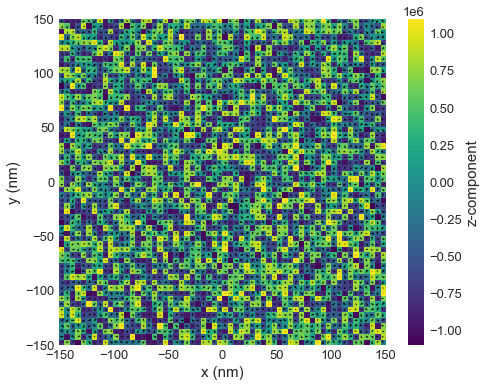

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 0)))

Ms = 1.1e6  # A/m

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

Relax the system and plot its magnetisation.

Running OOMMF (DockerOOMMFRunner) [2021/07/30 18:29]... (12.6 s)


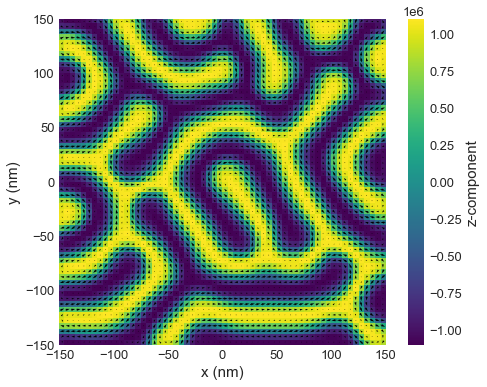

In [2]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

Now we have a magnetisation texture we can compute the magnetisation of the sample.

### DC Magnetisation

In [3]:
import mag2exp

In [4]:
mag2exp.magnetometry.magnetisation(system.m)

(-16899.17748228928, -2643.9487461497497, -4847.870347514056)

In [5]:
%%capture
mag_arr_v = []
H_arr_v = []
for H in np.linspace(0,1500000,51):
    system.energy.zeeman.H= (0,0,H)
    md.drive(system)
    _, _, temp_m = mag2exp.magnetometry.magnetisation(system.m)
    H_arr_v.append(H)
    mag_arr_v.append(temp_m)

mag_arr = []
H_arr = []
for H in np.linspace(1500000,-1500000,101):
    system.energy.zeeman.H= (0,0,H)
    md.drive(system)
    _, _, temp_m = mag2exp.magnetometry.magnetisation(system.m)
    H_arr.append(H)
    mag_arr.append(temp_m)
    
for H in np.linspace(-1500000,1500000,101):
    system.energy.zeeman.H= (0,0,H)
    md.drive(system)
    _, _, temp_m = mag2exp.magnetometry.magnetisation(system.m)
    H_arr.append(H)
    mag_arr.append(temp_m)

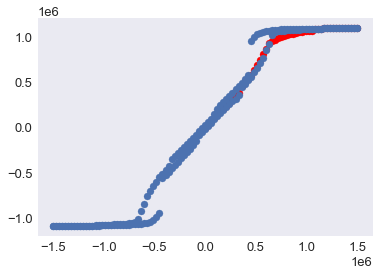

In [9]:
%matplotlib inline
plt.scatter(H_arr_v, mag_arr_v, c='r')
plt.scatter(H_arr, mag_arr)

\begin{equation}
    \tau = m \times B = \mu_0 m \times (H_{app}+H_{demag})
\end{equation}

### Importing Packages

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
Ms = 10.3*9.274e-24/(5e-10*5e-10*4e-10)
K1 = -1.58e6
K2 = 1.18e6
K = 1.18e6
H_mag = 0.5/(4*np.pi*1e-7)

In [3]:
Ms

955222.0

In [4]:
region = df.Region(p1=(0, 0, 0), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-13)
                 + mm.UniaxialAnisotropy(K1=K1, K2=K2, u=(0, 0, 1))
                 #+ mm.CubicAnisotropy(K=K, u1=(0, 0, 1), u2=(0, 1, 0))
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, H_mag)))

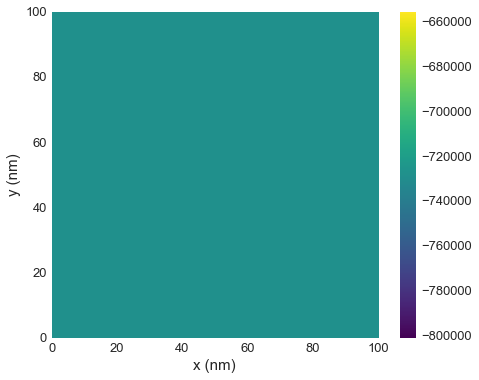

In [5]:
system.m = df.Field(mesh, dim=3, value=np.random.rand(3)-1, norm=Ms)
system.m.z.plane('z').mpl.plot()

In [6]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:46]... (5.3 s)


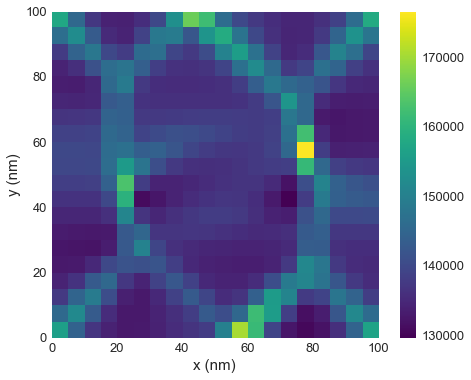

In [7]:
system.m.z.plane('z').mpl.plot()

\begin{align}
    {\bf M} &= \frac{d{\bf m}}{dV}, \\
    {\bf m} &= \int {\bf M} dV,\\
    {\bf m} &=  {\bf M} V,
\end{align}

where ${\bf M}$ is magnetisation field, ${\bf m}$ is the magnetic moment, and $V$ is the volume.

\begin{align}
    {\bf \tau} &= {\bf m} \times {\bf B}, \\
    &= \mu_0 {\bf m} \times \left({\bf H} + {\bf M} \right), \\
    &= \mu_0 {\bf m} \times {\bf H}, \\
    &= \mu_0 {\bf m} \times \left( {\bf H}_{app} + {\bf H}_{demag} \right),
\end{align}
where ${\bf \tau}$ is the torque, ${\bf B}$ is the magnetic flux density,  ${\bf H}$ is the total magnetic field, ${\bf H}_{app}$ is the applied magnetic field, and ${\bf H}_{demag}$ is the demagnetisation field.

In [8]:
def torque_2(system):
    total_field = 4*np.pi*1e-7*(oc.compute(system.energy.demag.effective_field, system) + system.energy.zeeman.H)
    #total_field = 4*np.pi*1e-7*df.Field(mesh=system.m.mesh, dim=3, value=system.energy.zeeman.H)
    norm_field = df.Field(system.m.mesh, dim=1, value=(system.m.norm.array != 0))
    volume = df.integral(norm_field * df.dV, direction='xyz')
    moment = system.m * volume #system.m.mesh.dV
    torque = (moment & total_field)
    
    norm_field = df.Field(system.m.mesh, dim=1, value=(system.m.norm.array != 0))
    volume = df.integral(norm_field * df.dV, direction='xyz')
    
    return (df.integral(torque * df.dV / volume**2 , direction='xyz'))

In [9]:
angles = np.linspace(0, 4*np.pi, 150)

torque_val_x = np.full_like(angles, np.nan)
torque_val_y = np.full_like(angles, np.nan)
torque_val_z = np.full_like(angles, np.nan)

In [10]:
for i, angle in enumerate(angles):
    system.energy.zeeman.H= (0,H_mag*np.sin(angle),H_mag*np.cos(angle))
    md.drive(system)
    torque_val_x[i], torque_val_y[i], torque_val_z[i] = torque_2(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:46]... (1.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:46]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:46]... (4.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:46]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:46]... (5.2 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:46]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (5.8 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (4.7 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (1.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (5.2 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (1.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (8.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (1.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 20:47]... (4.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/

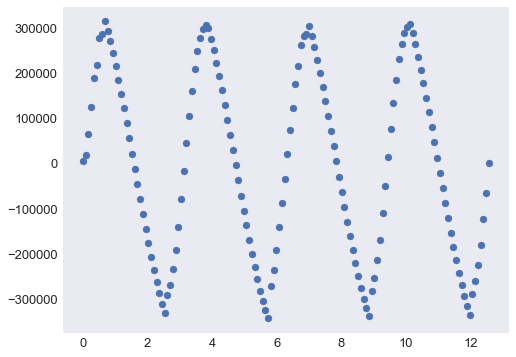

In [11]:
plt.scatter(angles, torque_val_x)

In [12]:
region = df.Region(p1=(0, 0, 0), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-13)
                 #+ mm.UniaxialAnisotropy(K1=K1, K2=K2, u=(0, 0, 1))
                 + mm.CubicAnisotropy(K=K, u1=(0, 0, 1), u2=(0, 1, 0))
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, H_mag)))

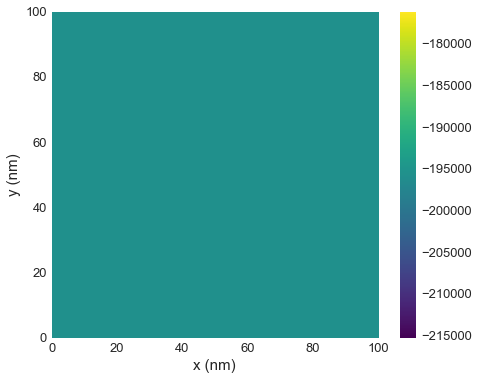

In [13]:
system.m = df.Field(mesh, dim=3, value=np.random.rand(3)-1, norm=Ms)
system.m.z.plane('z').mpl.plot()

Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:03]... (6.4 s)


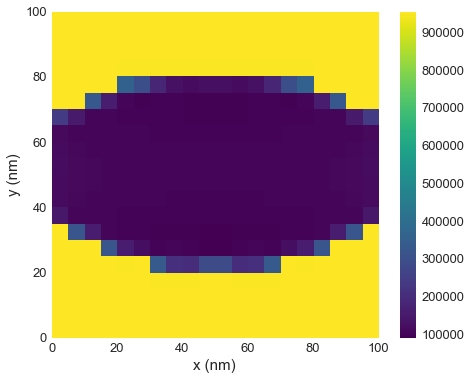

In [14]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)
system.m.z.plane('z').mpl.plot()

In [15]:
angles_2 = np.linspace(0, 4*np.pi, 150)

torque_val_x_2 = np.full_like(angles, np.nan)
torque_val_y_2 = np.full_like(angles, np.nan)
torque_val_z_2 = np.full_like(angles, np.nan)

for i, angle in enumerate(angles_2):
        system.energy.zeeman.H= (0,H_mag*np.sin(angle),H_mag*np.cos(angle))
        md.drive(system)
        torque_val_x_2[i], torque_val_y_2[i], torque_val_z_2[i] = torque_2(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (3.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (1.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (3.8 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (2.6 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (2.4 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (1.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (3.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (1.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (1.9 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/27 21:04]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/

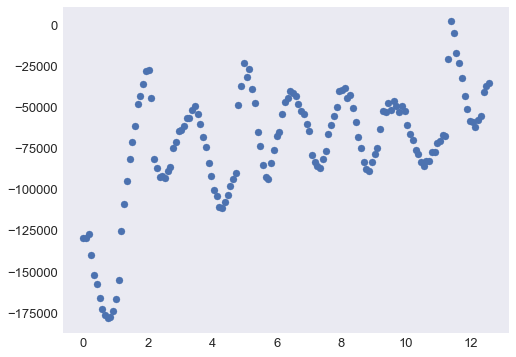

In [16]:
plt.scatter(angles_2, torque_val_x_2)

Increase applied field -> less sheered sin wave
Add general rotation about an axis
Fit curves and check against initial K values

In [ ]:
region = df.Region(p1=(0, 0, 0), p2=(50e-9, 50e-9, 50e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.CubicAnisotropy(K=K, u1=(0, 0, 1), u2=(0, 1, 0))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 397887)))
Ms = 384e3

def ms_fun(pos):
    x, y, z = pos
    if z > 25e-9:
        return Ms
    else:
        return 0

In [ ]:
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=ms_fun)
system.m.z.plane('z').mpl.plot()

In [ ]:
def magentisation_parallel(field):
    return df.integral(field.z * df.dV, direction='xyz')

def magentisation_perpendicular(field):
    return (df.integral(field.x * df.dV, direction='xyz'),
           df.integral(field.y * df.dV, direction='xyz'))

def magnetisation(field):
    norm_field = df.Field(field.mesh, dim=1, value=(field.norm.array != 0))
    volume = df.integral(norm_field * df.dV, direction='xyz') 
    return (df.integral(field * df.dV / volume , direction='xyz'))

In [ ]:

mp = df.integral(system.m.norm * df.dV / volume, direction='xyz') / Ms

In [ ]:
new_field = df.Field(mesh, dim=1, value=(system.m.norm.array != 0))

In [ ]:
df.integral(new_field * df.dV, direction='xyz') 

In [ ]:
magnetisation(system.m)

### Magnetisation data

Perform micromagnetic simulation or load from file.

In [ ]:
system.m.k3d

def torque(system):
    total_field = oc.compute(system.energy.demag.effective_field, system) + system.energy.zeeman.H
    torque = 4*np.pi*1e-7*(system.m & total_field)
    return (torque.x.array.sum(),torque.y.array.sum(),torque.z.array.sum()) # Some sort of normalisation

angle = np.pi/3
system.energy.zeeman.H = (0,H_mag*np.sin(angle),H_mag*np.cos(angle))
md.drive(system)

torque_2(system)

In [ ]:
H_mag = 5e6
print(4*np.pi*1e-7*H_mag)

print(0.5/(4*np.pi*1e-7))

In [ ]:
from scipy.optimize import curve_fit
def fun(angle, a,b,c,d):
    return a*np.sin(4*angle) + b*np.sin(8*angle) + c*np.sin(16*angle) + d*np.sin(32*angle)

In [ ]:
popt, pcov = curve_fit(fun, angles, torque_val_x, p0=[-1e15, 1e14, 1e14, -1e14])

In [ ]:
popt

In [ ]:
plt.plot(angles, torque_val_x - fun(angles,popt[0],popt[1], popt[2], popt[3]))

In [ ]:
region = df.Region(p1=(0, 0, 0), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.UniaxialAnisotropy(K=0.8e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))
Ms = 384e3
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms)
#system.m.z.plane('z').mpl.plot()
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms)
system.m.z.plane('z').mpl.plot()

In [ ]:
md = oc.MinDriver()
md.drive(system)

In [ ]:
system.m.plane('z').mpl.plot()

In [ ]:
angles = np.linspace(0, 2*np.pi, 70)
H_mag = 10e6



torque_val_x = np.zeros_like(angles)
torque_val_y = np.zeros_like(angles)
torque_val_z = np.zeros_like(angles)

for i, angle in enumerate(angles):
        system.energy.zeeman.H= (0,H_mag*np.sin(angle),H_mag*np.cos(angle))
        md.drive(system)
        torque_val_x[i], torque_val_y[i], torque_val_z[i] = torque(system)

In [ ]:
plt.scatter(angles, torque_val_x)